In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -- Preprocessing --
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

# -- Models --
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# -- Evaluation --
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

# Set plot style
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

print("All libraries for Phase 2 imported.")

All libraries for Phase 2 imported.


In [2]:
# --- Load our Master dataset ---
file_path = '../data/master_training_data.csv'
df_master = pd.read_csv(file_path)

print(f"Loaded master data with shape: {df_master.shape}")

# --- Define Target (y) ---
# Our target is the 'PURCHASE_FLG' column
y = df_master['PURCHASE_FLG']

# --- Define Features (X) for v1 Baseline ---
# We will ONLY use the simple customer segment features
# Using the EXACT column names from our analysis: 'AGE' and 'SEX_ID'
X = df_master[['AGE', 'SEX_ID']]

print("\n--- Target (y) ---")
print(y.value_counts())

print("\n--- Features (X) for v1 model ---")
display(X.head())
X.info()

Loaded master data with shape: (2517206, 37)

--- Target (y) ---
PURCHASE_FLG
0    2394817
1     122389
Name: count, dtype: int64

--- Features (X) for v1 model ---


,AGE,SEX_ID
0,25,f
1,25,f
2,25,f
3,25,f
4,25,f


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517206 entries, 0 to 2517205
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   AGE     int64 
 1   SEX_ID  object
dtypes: int64(1), object(1)
memory usage: 38.4+ MB


In [3]:
# --- Split Data into Training and Testing Sets ---
# We use 'stratify=y' to ensure our 3.3% imbalance is
# correctly represented in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # <-- CRITICAL for imbalanced data
)

print(f"Total samples: {len(X)}")
print(f"Training samples (80%): {len(X_train)}")
print(f"Testing samples (20%): {len(X_test)}")

print(f"\nTraining set 'Yes' percentage: {y_train.mean():.4f}")
print(f"Test set 'Yes' percentage:     {y_test.mean():.4f}")

Total samples: 2517206
Training samples (80%): 2013764
Testing samples (20%): 503442

Training set 'Yes' percentage: 0.0486
Test set 'Yes' percentage:     0.0486


In [4]:
# --- Build the Preprocessing Pipeline ---

# 1. Define lists of column names by their type
numeric_features = ['AGE']
categorical_features = ['SEX_ID']

# 2. Create the transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# 3. Create the 'preprocessor'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("--- 'v1' Preprocessing pipeline built successfully ---")
display(preprocessor)

--- 'v1' Preprocessing pipeline built successfully ---


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [5]:
# --- Calculate Class Weights ---

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"Calculated class weights to handle imbalance:")
print(f"The model will treat class 0 ('No') with weight: {class_weight_dict[0]:.2f}")
print(f"The model will treat class 1 ('Yes') with weight: {class_weight_dict[1]:.2f}")

Calculated class weights to handle imbalance:
The model will treat class 0 ('No') with weight: 0.53
The model will treat class 1 ('Yes') with weight: 10.28


In [6]:
# --- Dictionary to store results ---
model_results = {}

# --- Model 1: Logistic Regression ---
print("\n=========================================")
print("Training Logistic Regression (v1)...")

# 1. Create the full pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, class_weight=class_weight_dict))
])

# 2. Train the pipeline
log_reg_pipeline.fit(X_train, y_train)

# 3. Get predictions
y_pred_log_reg = log_reg_pipeline.predict(X_test)

# 4. Evaluate and store
model_results['Logistic Regression (v1)'] = {
    'Accuracy': accuracy_score(y_test, y_pred_log_reg),
    'F1-Score (Yes)': f1_score(y_test, y_pred_log_reg, pos_label=1)
}
print(f"--- Results for Logistic Regression (v1) ---")
print(classification_report(y_test, y_pred_log_reg, target_names=['No (0)', 'Yes (1)']))

# --- Model 2: Decision Tree ---
print("\n=========================================")
print("Training Decision Tree (v1)...")

# 1. Create the full pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42, max_depth=10, class_weight=class_weight_dict))
])

# 2. Train the pipeline
tree_pipeline.fit(X_train, y_train)

# 3. Get predictions
y_pred_tree = tree_pipeline.predict(X_test)

# 4. Evaluate and store
model_results['Decision Tree (v1)'] = {
    'Accuracy': accuracy_score(y_test, y_pred_tree),
    'F1-Score (Yes)': f1_score(y_test, y_pred_tree, pos_label=1)
}
print(f"--- Results for Decision Tree (v1) ---")
print(classification_report(y_test, y_pred_tree, target_names=['No (0)', 'Yes (1)']))


Training Logistic Regression (v1)...
--- Results for Logistic Regression (v1) ---
              precision    recall  f1-score   support

      No (0)       0.95      0.54      0.69    478964
     Yes (1)       0.05      0.47      0.09     24478

    accuracy                           0.54    503442
   macro avg       0.50      0.51      0.39    503442
weighted avg       0.91      0.54      0.66    503442


Training Decision Tree (v1)...
--- Results for Decision Tree (v1) ---
              precision    recall  f1-score   support

      No (0)       0.95      0.65      0.77    478964
     Yes (1)       0.05      0.38      0.09     24478

    accuracy                           0.64    503442
   macro avg       0.50      0.51      0.43    503442
weighted avg       0.91      0.64      0.74    503442




--- v1 Baseline Model Scores ---


,Accuracy,F1-Score (Yes)
Logistic Regression (v1),0.540904,0.090985
Decision Tree (v1),0.636806,0.091791


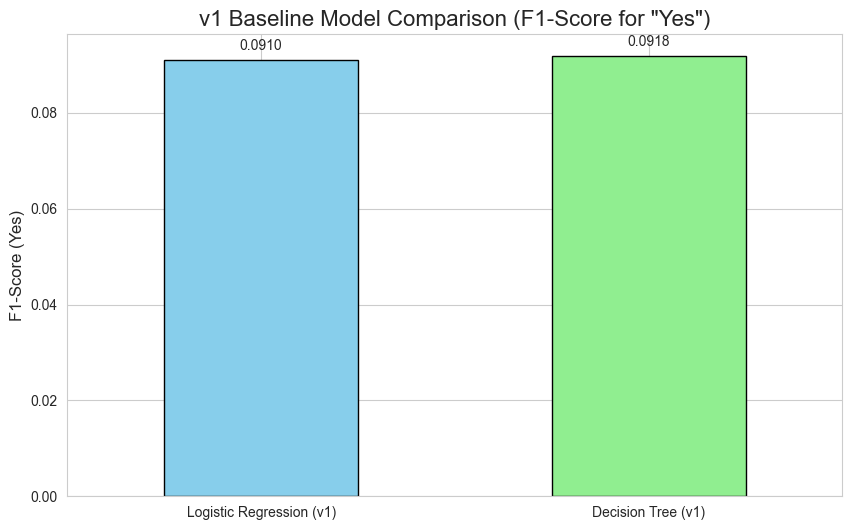


This is our 'score to beat'.
Our 'v2' models in the next notebook will try to dramatically improve this F1-Score.


In [7]:
# --- Visualize Model Comparison ---

results_df = pd.DataFrame(model_results).T

print("\n--- v1 Baseline Model Scores ---")
display(results_df)

# --- Plot the F1-Score (for 'Yes') ---
plt.figure(figsize=(10, 6))
ax = results_df['F1-Score (Yes)'].plot(
    kind='bar',
    color=['skyblue', 'lightgreen'],
    edgecolor='black'
)
ax.set_title('v1 Baseline Model Comparison (F1-Score for "Yes")', fontsize=16)
ax.set_ylabel('F1-Score (Yes)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Add score labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

print("\nThis is our 'score to beat'.")
print("Our 'v2' models in the next notebook will try to dramatically improve this F1-Score.")